# 1. 序列到序列学习(seq2seq)

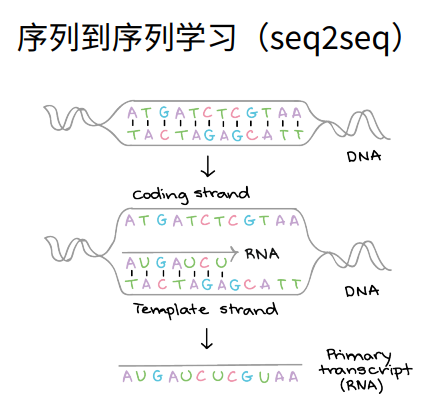

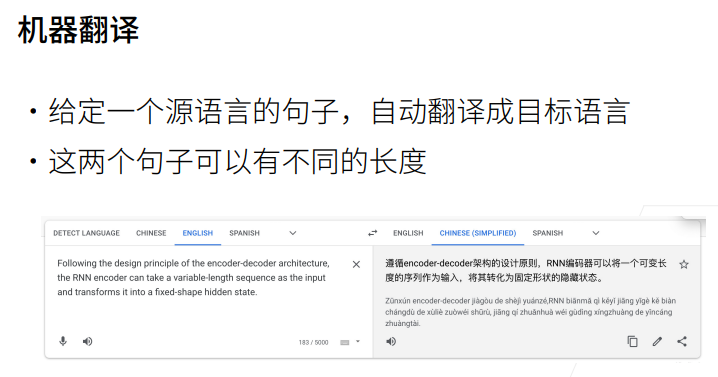

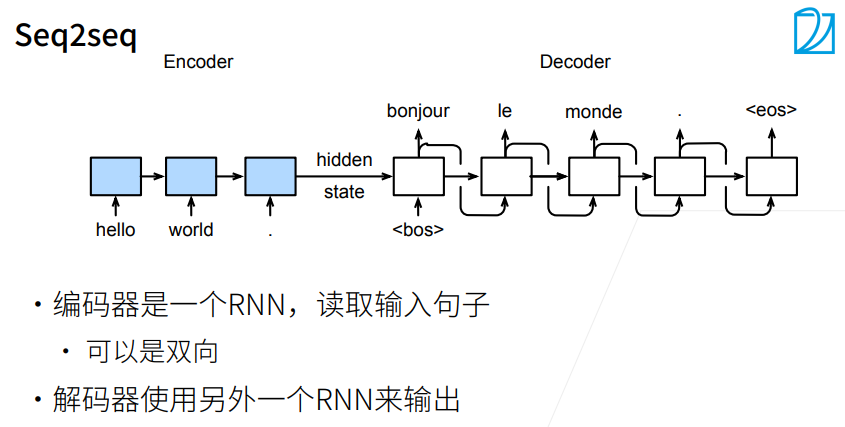

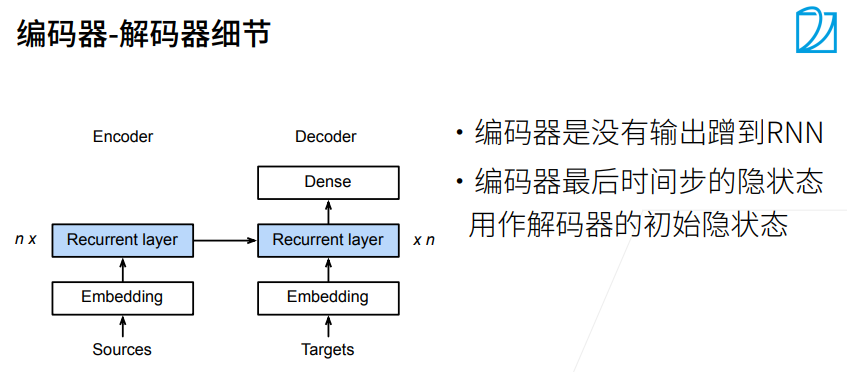

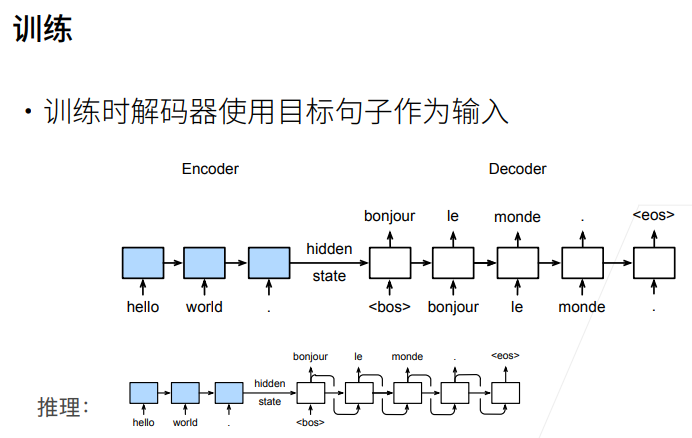

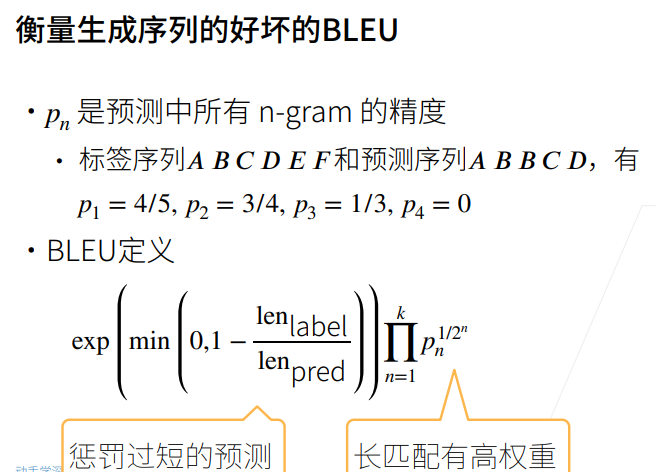

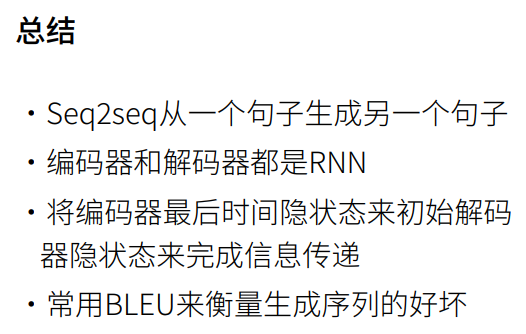

# 2. 序列到序列学习(seq2seq)

In [1]:
# 序列到序列学习（seq2seq）
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l
import os

In [2]:
# 实现循环神经网络编码器
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 创建一个嵌入层，用于将输入的单词索引转换为词嵌入向量
        self.embedding = nn.Embedding(vocab_size, embed_size) 
        # 创建一个GRU循环神经网络模型
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout) 
        
    def forward(self, X, *args):
        # 将输入序列进行词嵌入操作
        X = self.embedding(X) 
        # 将输入序列的维度进行转置，以适应RNN模型的输入格式要求
        X = X.permute(1, 0, 2) 
        # 将转置后的输入序列输入到RNN模型中，得到输出和最终的隐藏状态
        output, state = self.rnn(X)
        # 返回输出和最终隐藏状态
        return output, state

In [3]:
# 上述编码器的实现
# 创建一个Seq2SeqEncoder对象，设置词汇表大小为10，嵌入维度为8，隐藏状态维度为16，层数为2
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)  
# 将编码器设置为评估模式，这将影响一些层的行为，如dropout层
encoder.eval()
# 创建一个形状为(4, 7)的输入张量X，用于模拟4个样本，每个样本有7个单词
X = torch.zeros((4,7), dtype=torch.long)
# 将输入张量X传递给编码器，得到输出张量output和最终隐藏状态state
output, state = encoder(X)
# 打印输出张量的形状
output.shape

torch.Size([7, 4, 16])

In [4]:
# 打印最终隐藏状态的形状
state.shape

torch.Size([2, 4, 16])

In [5]:
# 解码器
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        # 创建一个嵌入层，用于将输入的单词索引转换为词嵌入向量
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 创建一个GRU循环神经网络模型
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)   
        # 创建一个全连接层，用于将隐藏状态映射到词汇表大小的向量
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, *args):
        # 返回编码器输出的最终隐藏状态作为解码器的初始隐藏状态
        return enc_outputs[1]
    
    def forward(self, X, state):
        # 将输入序列进行词嵌入操作，并进行维度转置
        X = self.embedding(X).permute(1,0,2)
        # 将编码器的最终隐藏状态进行复制，用于和每个解码器输入进行拼接
        context = state[-1].repeat(X.shape[0],1,1)
        # 将词嵌入序列和编码器最终隐藏状态拼接起来作为解码器输入
        X_and_context = torch.cat((X, context), 2)
        # 将拼接后的输入序列和初始隐藏状态输入到RNN模型中
        output, state = self.rnn(X_and_context, state)
        # 将RNN模型的输出通过全连接层映射到词汇表大小的向量，并进行维度转置
        output = self.dense(output).permute(1,0,2)
        # 返回输出和最终隐藏状态
        return output, state

In [6]:
# 实例化解码器
# 创建一个Seq2SeqDecoder对象，设置词汇表大小为10，嵌入维度为8，隐藏状态维度为16，层数为2
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)  
# 将解码器设置为评估模式，这将影响一些层的行为，如dropout层
decoder.eval()
# 使用编码器的输出来初始化解码器的隐藏状态
state = decoder.init_state(encoder(X))
# 将输入张量X和初始化的隐藏状态传递给解码器，得到输出张量output和更新后的隐藏状态state
output, state = decoder(X, state)
# 打印输出张量和隐藏状态的形状
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [7]:
# 通过零值化屏蔽不相关的项
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    # 获取序列的最大长度
    maxlen = X.size(1)
    # 创建一个掩码，标记不相关的项为False
    mask = torch.arange((maxlen), dtype=torch.float32,
                       device=X.device)[None, :] < valid_len[:, None]
    # 将不相关的项零值化，即用指定的值进行填充
    X[~mask] = value
    return X
# 创建一个输入张量X，用于演示
X = torch.tensor([[1,2,3],[4,5,6]])
# 调用sequence_mask函数，对输入张量X进行屏蔽操作，将填充的项标出来
sequence_mask(X, torch.tensor([1,2])) 

tensor([[1, 0, 0],
        [4, 5, 0]])

In [8]:
# 我们还可以使用此函数屏蔽最后几个轴上的所有项
# 创建一个全为1的输入张量X，用于演示
X = torch.ones(2,3,4)
# 调用sequence_mask函数，对输入张量X进行屏蔽操作，将最后几个轴上的所有项标出来，使用-1进行填充   
sequence_mask(X, torch.tensor([1,2]),value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [9]:
# 通过扩展softmax交叉熵损失函数来遮蔽不相关的预测
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    def forward(self, pred, label, valid_len):
        # 创建一个与标签张量label形状相同的张量，所有元素都为1，用作权重
        weights = torch.ones_like(label)
        # 使用sequence_mask函数对权重张量进行遮蔽操作，将不相关的项标出来
        weights = sequence_mask(weights, valid_len)
        # 设置损失函数的计算方式为不进行降维
        self.reduction = 'none'
        # 调用父类的forward方法计算未加权的交叉熵损失
        unweighted_loss = super(MaskedSoftmaxCELoss,self).forward(pred.permute(0,2,1),label)    
        # 将未加权的损失乘以权重，然后在第1个维度上求均值，得到加权的损失
        weighted_loss = (unweighted_loss * weights).mean(dim=1) # 有效的留下来，没效的全部变为0
        # 返回加权的损失张量
        return weighted_loss

In [10]:
# 代码健壮性检查
# 实例化MaskedSoftmaxCELoss类，创建一个损失函数对象
loss = MaskedSoftmaxCELoss() 
# 调用损失函数对象的forward方法，计算损失      
loss(torch.ones(3,4,10), torch.ones((3,4),dtype=torch.long),torch.tensor([4,2,0])) 

tensor([2.3026, 1.1513, 0.0000])

In [11]:
# 训练
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        # 如果是线性层
        if type(m) == nn.Linear:
            # 使用Xavier均匀初始化权重
            nn.init.xavier_uniform_(m.weight)
        # 如果是GRU层
        if type(m) == nn.GRU:
            # 对于GRU层的每个参数
            for param in m._flat_weights_names:
                # 如果是权重参数
                if "weight" in param:
                    # 使用Xavier均匀初始化该权重参数
                    nn.init.xavier_uniform_(m._parameters[param])
    
    # 应用xavier_init_weights函数，对网络模型的参数进行初始化
    net.apply(xavier_init_weights)
    # 将网络模型移动到指定设备上
    net.to(device)
    # 创建Adam优化器，将网络模型的参数传入优化器
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    # 创建MaskedSoftmaxCELoss损失函数对象
    loss = MaskedSoftmaxCELoss()
    # 将网络模型设置为训练模式
    net.train()
    # 创建动画绘制对象，用于绘制损失随训练epoch的变化情况
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[10, num_epochs])  
    
    for epoch in range(num_epochs):
        # 创建计时器对象，用于计算每个epoch的训练时间
        timer = d2l.Timer()
        # 创建累加器对象，用于累加损失和标记的数量
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            # 将输入数据移动到指定设备上
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            # 创建起始符号的张量bos，并移动到指定设备上
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                              device=device).reshape(-1,1)
            # 构造解码器的输入，将bos和去除最后一列的标签张量Y拼接起来
            dec_input = torch.cat([bos, Y[:,:-1]],1)
            # 前向传播，得到预测结果Y_hat
            Y_hat, _ = net(X, dec_input, X_valid_len)
            # 计算损失
            l = loss(Y_hat, Y, Y_valid_len)
            # 反向传播，计算梯度
            l.sum().backward()
            # 对梯度进行裁剪，防止梯度爆炸
            d2l.grad_clipping(net,1)
            # 计算标记的数量
            num_tokens = Y_valid_len.sum()
            # 更新模型参数
            optimizer.step()
            # 使用torch.no_grad()上下文管理器，关闭梯度计算，避免计算图的构建
            with torch.no_grad():
                # 累加损失和标记的数量
                metric.add(l.sum(), num_tokens)
        # 每10个epoch打印一次损失
        if (epoch + 1) % 10 == 0:
            # 绘制损失随训练epoch的变化情况
            animator.add(epoch+1, (metric[0]/metric[1],))   
    # 打印最终的损失值和训练速度
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
         f'tokens/sec on {str(device)}')      

In [12]:
def read_data_nmt():
    """载入 “英语-法语” 数据集 """
    # 下载并解压“英语-法语”数据集
    data_dir = d2l.download_extract('fra-eng')
    # 打开数据集文件
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        # 读取文件内容并返回
        return f.read()

In [13]:
def preprocess_nmt(text):
    """预处理 “英语-法语” 数据集"""
    def no_space(char, prev_char):
        # 如果当前字符是逗号、句号、问号或感叹号，并且前一个字符不为空，则返回True，表示需要在当前字符前面添加一个空格。否则返回False。
        return char in set(',.!?') and prev_char != ''
    
    # 将特殊字符替换为空格，并将文本转换为小写
    text = text.replace('\u202f', ' ').replace('\xa0',' ').lower()
    # 对于文本中的每个字符，如果不是首字符且当前字符为逗号、句号、问号或感叹号，并且前一个字符不为空，则在字符前面添加一个空格
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    # 将处理后的字符列表连接成一个字符串并返回
    return ''.join(out)

In [14]:
def tokenize_nmt(text, num_examples=None):
    """词元化 “英语-法语” 数据数据集 """
    # 初始化源语言和目标语言的列表
    source, target = [], []
    # 按行循环遍历文本的每一行
    for i, line in enumerate(text.split('\n')):
        # 如果指定了num_examples，并且已处理的行数超过num_examples，则结束循环
        if num_examples and i > num_examples:
            break
        # 将每行文本按制表符分割成两部分，分别是源语言和目标语言
        parts = line.split('\t')
        # 如果分割后的部分数量为2
        if len(parts) == 2:
            # 将源语言部分按空格分割为词元，并添加到源语言列表中
            source.append(parts[0].split(' '))
            # 将目标语言部分按空格分割为词元，并添加到目标语言列表中
            target.append(parts[1].split(' '))
    # 返回源语言和目标语言列表
    return source, target

In [15]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    # 如果文本序列的长度超过了num_steps
    if len(line) > num_steps:
        # 将文本序列截断为num_steps长度并返回
        return line[:num_steps]
    # 否则，在文本序列末尾填充padding_token，使其长度达到num_steps
    return line + [padding_token] * (num_steps - len(line))

In [16]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    # 将文本序列中的词元转换为对应的索引值
    lines = [vocab[l] for l in lines]
    # 在每个文本序列末尾添加结束符<eos>
    lines = [l + [vocab['<eos>']] for l in lines]
    # 将文本序列截断或填充为指定长度，并转换为Tensor
    array = torch.tensor([ truncate_pad(l, num_steps, vocab['<pad>']) for l in lines ])
    # 计算每个序列的有效长度，即非填充部分的长度
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    # 返回转换后的Tensor和有效长度
    return array, valid_len

In [17]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表"""
    # 预处理文本数据，将英语-法语数据集读取并进行处理
    text = preprocess_nmt(read_data_nmt())
    # 对文本数据进行词元化处理
    source, target = tokenize_nmt(text, num_examples)
    # 构建源语言词汇表
    src_vocab = d2l.Vocab(source, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    # 构建目标语言词汇表
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    # 将源语言文本序列转换为Tensor，并计算有效长度
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)  
    # 将目标语言文本序列转换为Tensor，并计算有效长度
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    # 将转换后的数据和有效长度组合成数据数组
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    # 加载数据数组，构建数据迭代器
    data_iter = d2l.load_array(data_arrays, batch_size)
    # 返回数据迭代器和词汇表
    return data_iter, src_vocab, tgt_vocab

In [18]:
help(d2l.load_data_nmt)

Help on function load_data_nmt in module d2l.torch:

load_data_nmt(batch_size, num_steps, num_examples=600)
    Return the iterator and the vocabularies of the translation dataset.



loss 0.018, 16513.3 tokens/sec on cuda:0


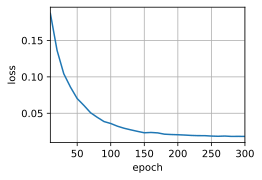

In [19]:
# 创建和训练一个循环神经网络 “编码器-解码器” 模型
# 设置嵌入层大小(embed_size)、隐藏层大小(num_hiddens)、层数(num_layers)和丢弃率(dropout)的数值
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
# 设置批量大小(batch_size)和时间步数(num_steps)的数值
batch_size, num_steps = 64, 10
# 设置学习率(lr)、训练轮数(num_epochs)和设备(device)
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

# 加载训练数据集和词汇表
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)  
# 创建编码器和解码器
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)   
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)   
# 创建整个编码器-解码器模型
net = d2l.EncoderDecoder(encoder, decoder)
# 训练序列到序列模型
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [20]:
# 预测
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                   device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 将模型设为评估模式，用于预测
    net.eval()
    # 将源语言句子转换为词元，并添加<eos>作为结束符
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    # 计算有效长度
    enc_valid_len = torch.tensor([len(src_tokens)],device=device)
    # 截断或填充源语言句子
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>']) 
    # 将源语言句子转换为张量，并添加一个维度表示批量大小
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)   
    # 使用编码器生成编码器输出
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    # 初始化解码器状态
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len) 
    # 初始化解码器输入
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),dim=0)    
    # 初始化输出序列和注意力权重序列
    output_seq, attention_weight_seq = [], []
    # 循环生成预测结果，最多进行num_steps次迭代
    for _ in range(num_steps):
        # 使用解码器生成输出和更新解码器状态
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 获取解码器输出中概率最高的词元作为下一个解码器输入
        dec_X = Y.argmax(dim=2)
        # 获取预测结果
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 如果需要保存注意力权重，则将当前的注意力权重添加到注意力权重序列中
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 判断是否预测到结束符
        if pred == tgt_vocab['<eos>']:
            break
        # 将预测结果添加到输出序列
        output_seq.append(pred)
    # 将输出序列转换为字符串，并返回输出序列和注意力权重序列（如果需要）
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [21]:
# BLEU的代码实现
def bleu(pred_seq, label_seq, k):
    """计算 BLEU"""
    # 将预测序列和标签序列分割成词元列表
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    # 计算预测序列和标签序列的长度
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    # 初始化得分，并根据预测序列和标签序列的长度比例进行调整
    score = math.exp(min(0,1-len_label/len_pred))
    # 对每个n-gram进行计算，其中k为最大n-gram的大小
    for n in range(1, k+1):
        # 初始化匹配次数和标签序列中的n-gram计数器
        num_matches, label_subs = 0, collections.defaultdict(int)
        # 遍历标签序列，计算标签序列中的n-gram出现次数
        for i in range(len_label - n + 1):
            # 更新标签序列中n-gram的计数
            label_subs[''.join(label_tokens[i:i+n])] += 1
        # 遍历预测序列，统计预测序列中与标签序列n-gram匹配的次数
        for i in range(len_pred - n + 1):
            # 如果预测序列中的n-gram在标签序列中出现，则增加匹配次数，并减少标签序列中该n-gram的计数
            if label_subs[''.join(pred_tokens[i:i+n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i+n])] -= 1
        # 根据匹配次数和预测序列的长度计算得分
        score *= math.pow(num_matches/(len_pred-n+1), math.pow(0.5,n))
    # 返回计算得到的BLEU得分
    return score

In [22]:
# 将几个英语句子翻译成法语
# 定义英语句子列表
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
# 定义法语句子列表
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
# 使用zip函数迭代英语句子和法语句子的对应元素
for eng, fra in zip(engs, fras):
    # 调用predict_seq2seq函数进行翻译预测，并获取翻译结果和注意力权重序列
    translation, attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    # 调用bleu函数计算翻译结果的BLEU分数
    # 打印英语句子、翻译结果和BLEU分数
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va  !, bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est bon tomber !, bleu 0.447
i'm home . => je suis parti retard tom . de de de de, bleu 0.316
